# Notebook Overview (GRU + all cols + more vis)

#### In this notebook:
- Models with GRU layer
- Models with Convo1D layers
- Model with all columns of dataset
- Model for close prices
- Better/more visualization

Models from this notebook are currently not being used in our application and still remain in development. We now have a much more accurate closing price model using a layer of GRU (instead of LSTM) however, it still does not beat out our model with an LSTM layer when it comes to loss, rmse, etc. 

## Global imports

In [220]:
import numpy as np
import math
import seaborn as sns
from datetime import datetime
import pandas_datareader as pdr
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
plt.style.use("ggplot")

## Importing our data

In [221]:
start_date = datetime(2014, 1, 1)
end_date = datetime(2022, 1, 1)
sq = pdr.DataReader('GOOG', 'stooq', start_date, end_date)
# Reindex our dataframe to be in ascending order by date.
sq = sq.reindex(index=sq.index[::-1])
sq

,Open,High,Low,Close,Volume
Date,,,,,
2014-03-27,28.4000,28.4000,27.6460,27.9230,261040
2014-03-28,28.0600,28.3215,27.9335,27.9995,820060
2014-03-31,28.3445,28.3500,27.8465,27.8485,215440
2014-04-01,27.9355,28.4225,27.9355,28.3580,158640
2014-04-02,29.9995,30.2415,28.1095,28.3500,2933940
...,...,...,...,...,...
2021-12-27,147.4640,148.4260,147.2500,148.0640,13259320
2021-12-28,148.3740,148.3740,145.9360,146.4480,18635840
2021-12-29,146.4300,147.1840,145.5040,146.5040,17024720


## Data Visualization / Exploration

In [222]:
sq.info()
# Notice that Date is not listed here as a column

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1957 entries, 2014-03-27 to 2021-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1957 non-null   float64
 1   High    1957 non-null   float64
 2   Low     1957 non-null   float64
 3   Close   1957 non-null   float64
 4   Volume  1957 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 91.7 KB


array([[<AxesSubplot: title={'center': 'Open'}>,
        <AxesSubplot: title={'center': 'High'}>],
       [<AxesSubplot: title={'center': 'Low'}>,
        <AxesSubplot: title={'center': 'Close'}>],
       [<AxesSubplot: title={'center': 'Volume'}>, <AxesSubplot: >]],
      dtype=object)

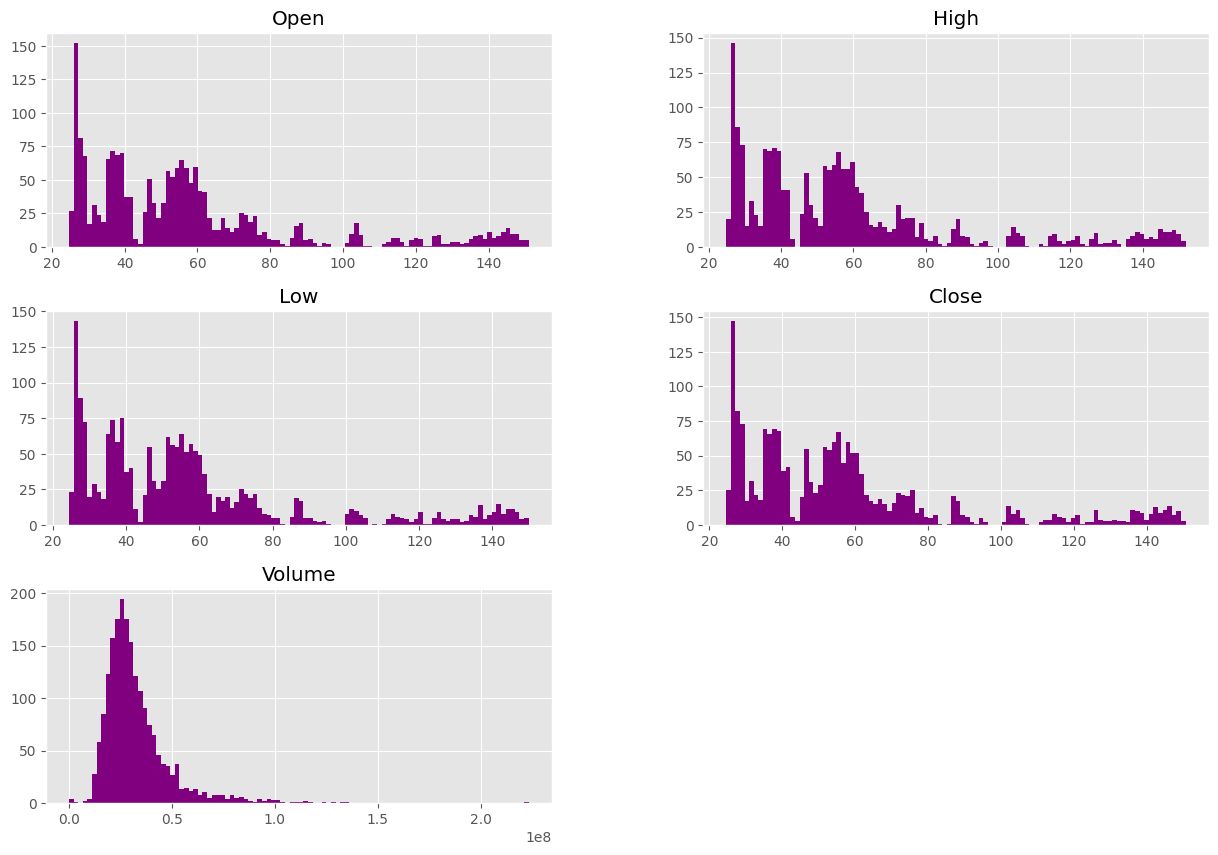

In [223]:
sq.hist(bins=100, figsize=(15,10), color="purple")

array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>], dtype=object)

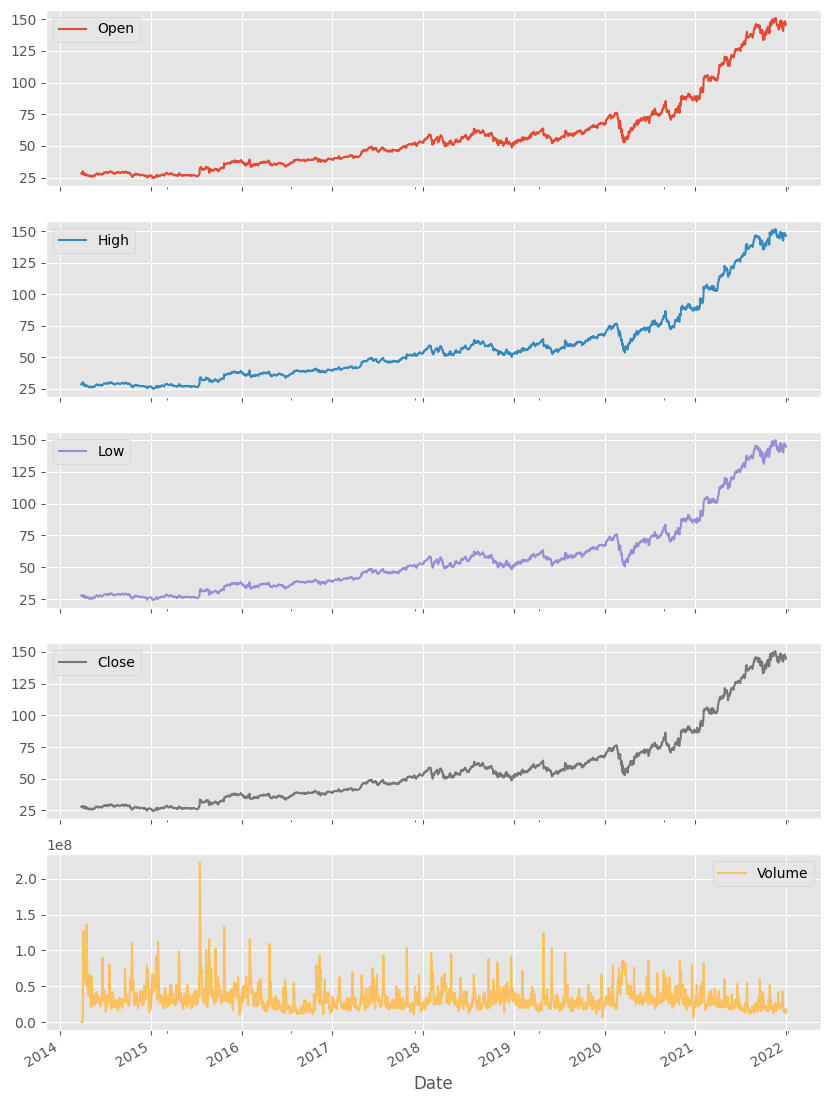

In [224]:
# Plotting all of our column data
sq.plot(legend=True, subplots=True, figsize = (10,15))

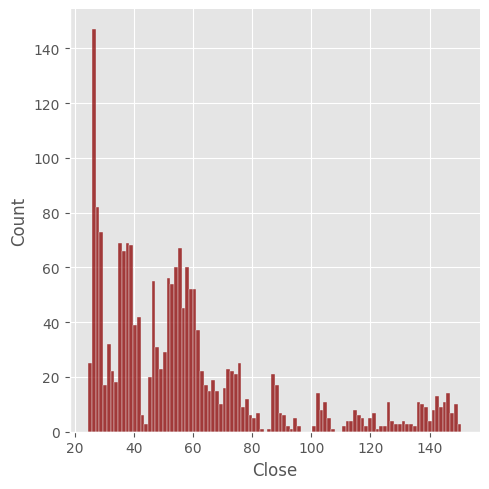

In [225]:
# Plot with nulls dropped
sns.displot(sq["Close"].dropna(), bins=100, color="darkred")

In [226]:
# Stats on each column
sq.describe()

,Open,High,Low,Close,Volume
count,1957.000000,1957.000000,1957.000000,1957.000000,1.957000e+03
mean,57.821317,58.366844,57.296617,57.854187,3.286036e+07
std,30.763351,31.055370,30.508545,30.797623,1.663069e+07
min,24.732500,24.799000,24.378000,24.627500,1.586400e+05
25%,36.143500,36.406500,35.827500,36.055500,2.283568e+07
50%,52.134000,52.737500,51.422500,52.004500,2.892094e+07
75%,65.493000,66.290000,65.243500,65.773000,3.779158e+07
max,151.000000,151.850000,149.888000,150.709000,2.232980e+08


## Preprocessing

In [227]:
# Let's quickly view incomplete rows (if any)
sample_incomplete_rows = sq[sq.isnull().any(axis=1)].head()
sample_incomplete_rows

,Open,High,Low,Close,Volume
Date,,,,,


#### Imputing

In [228]:
# Normally we would want to do this for these kinds of data sets. It seems the data we are pulling really doesn't include null vals most of the time.
# Leaving this step in just in case a situation arises where we have a null value.
sq.reset_index(drop=True, inplace=True)
sq.fillna(sq.mean(), inplace=True)

#### Extracting and scaling close data

In [229]:
#Create dataframe for close column
data = sq.filter(['Close'])
#Convert dataframe to numpy array
dataset = data.values
#Get num rows to train model
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

1566

In [230]:
#Scale data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.02613786],
       [0.02674461],
       [0.02554697],
       ...,
       [0.96664856],
       [0.96266701],
       [0.95218172]])

## Test / Train sets

#### For the full data (open, close, volume, etc.)

In [231]:
from sklearn.model_selection import train_test_split

X = []
Y = []
window_size = 100
for i in range (1, len(sq) - window_size, 1):
    first = sq.iloc[i,2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((sq.iloc[i + j, 2] - first) / first)
    temp2.append((sq.iloc[i + window_size, 2] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))
print(len(X))
print(len(Y))

1856
1856


In [232]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0], 100)
test_X = test_X.reshape(test_X.shape[0], 100)
train_Y = train_Y.reshape(train_Y.shape[0])
test_Y = test_Y.reshape(test_Y.shape[0])

print(len(train_X))
print(len(test_X))

1484
372


In [233]:
train_X = train_X.reshape(train_X.shape[0],100,1)
test_X = test_X.reshape(test_X.shape[0],100,1)

#### For just closing prices (What we really care about)

In [234]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:training_data_len , :]
#Split data into x_train and y_train sets
x_train_close = []
y_train_close = []

for i in range(60, len(train_data)):
  x_train_close.append(train_data[i-60:i,0])
  y_train_close.append(train_data[i, 0])

  if i<=61:
    print(x_train_close)
    print(y_train_close)
    print()

[array([0.02613786, 0.02674461, 0.02554697, 0.029588  , 0.02952455,
       0.03061115, 0.02006242, 0.01808354, 0.02472607, 0.02839037,
       0.01919393, 0.01508945, 0.01585086, 0.01740541, 0.02537644,
       0.01727057, 0.01430424, 0.016759  , 0.013638  , 0.01293211,
       0.00937092, 0.00975559, 0.0139394 , 0.01352696, 0.01538687,
       0.01403061, 0.01398302, 0.00895849, 0.00690426, 0.0073167 ,
       0.01038217, 0.01481978, 0.0160769 , 0.013523  , 0.01087788,
       0.01113565, 0.01439942, 0.01476029, 0.01839683, 0.02082383,
       0.02385362, 0.02910816, 0.02741481, 0.0267803 , 0.02670495,
       0.0243414 , 0.02077624, 0.0206652 , 0.0243295 , 0.02529316,
       0.0275893 , 0.02696668, 0.02628855, 0.02331825, 0.02348084,
       0.02051451, 0.02001087, 0.02411932, 0.02472607, 0.02530506])]
[0.02871158734627996]

[array([0.02613786, 0.02674461, 0.02554697, 0.029588  , 0.02952455,
       0.03061115, 0.02006242, 0.01808354, 0.02472607, 0.02839037,
       0.01919393, 0.01508945, 0.01

In [235]:
#Convert the x_train and y_train to numpy arrays

x_train_close, y_train_close = np.array(x_train_close), np.array(y_train_close)
x_train_close

array([[0.02613786, 0.02674461, 0.02554697, ..., 0.02411932, 0.02472607,
        0.02530506],
       [0.02674461, 0.02554697, 0.029588  , ..., 0.02472607, 0.02530506,
        0.02871159],
       [0.02554697, 0.029588  , 0.02952455, ..., 0.02530506, 0.02871159,
        0.02858072],
       ...,
       [0.24874783, 0.23962675, 0.24695931, ..., 0.37835051, 0.38213774,
        0.3859805 ],
       [0.23962675, 0.24695931, 0.22991874, ..., 0.38213774, 0.3859805 ,
        0.36138926],
       [0.24695931, 0.22991874, 0.22369261, ..., 0.3859805 , 0.36138926,
        0.36509321]])

In [236]:
#Reshape data
x_train_close = np.reshape(x_train_close, (x_train_close.shape[0], x_train_close.shape[1], 1))
x_train_close.shape

(1506, 60, 1)

In [237]:
#Create the testing data set
test_data = scaled_data[training_data_len -60:, :]
#Create the data sets x_test and y_test
x_test_close = []
y_test_close = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test_close.append(test_data[i-60:i, 0])

In [238]:
x_test_close = np.array(x_test_close)
x_test_close = np.reshape(x_test_close, (x_test_close.shape[0], x_test_close.shape[1], 1))

## Model

#### For the full data (open, close, volume, etc.)

In [239]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, GRU, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import RootMeanSquaredError

model = tf.keras.Sequential()

model.add(Conv1D(64, kernel_size=3, activation="relu", input_shape=(100, 1)))
model.add(Conv1D(128, kernel_size=3, activation="relu"))
model.add(Conv1D(64, kernel_size=3, activation="relu"))
model.add(MaxPooling1D(2))

model.add(Bidirectional(GRU(100, return_sequences=False)))

model.add(Dropout(0.5))

model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

result = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=5, batch_size=200, verbose=1, shuffle=True)

Epoch 1/5
8/8 [==============================] - 7s 517ms/step - loss: 0.0128 - mse: 0.0128 - mae: 0.0887 - val_loss: 0.0046 - val_mse: 0.0046 - val_mae: 0.0515
Epoch 2/5
8/8 [==============================] - 3s 434ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0450 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0403
Epoch 3/5
8/8 [==============================] - 3s 421ms/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0448 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0282
Epoch 4/5
8/8 [==============================] - 3s 414ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0339 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0286
Epoch 5/5
8/8 [==============================] - 3s 418ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0323 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0258


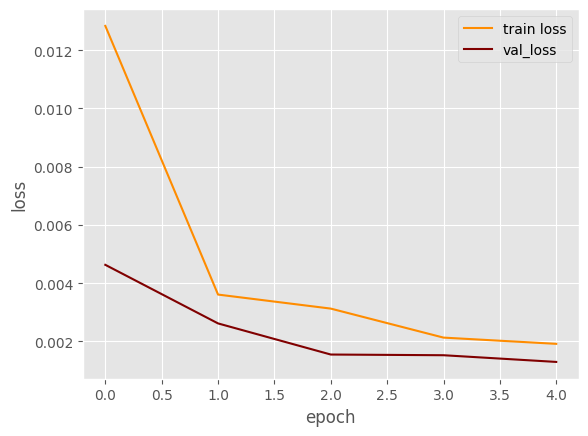

In [240]:
# Plot our loss over each epoch. We see our loss start to plateu after our 5 epochs which usually means that's a good place to stop.
plt.plot(result.history['loss'], label='train loss', color="darkorange")
plt.plot(result.history['val_loss'], label='val_loss', color="maroon")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [241]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_56 (Conv1D)          (None, 98, 64)            256       
                                                                 
 conv1d_57 (Conv1D)          (None, 96, 128)           24704     
                                                                 
 conv1d_58 (Conv1D)          (None, 94, 64)            24640     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 47, 64)           0         
 g1D)                                                            
                                                                 
 bidirectional_16 (Bidirecti  (None, 200)              99600     
 onal)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 200)             

In [242]:
model.evaluate(test_X, test_Y)

12/12 [==============================] - 0s 28ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0258


[0.00129513640422374, 0.00129513640422374, 0.02576483227312565]

#### For just the closing prices (What we care about)

In [243]:
model_close = tf.keras.Sequential()

model_close.add(Conv1D(64, kernel_size=3, activation="relu", input_shape=(60, 1)))
model_close.add(Conv1D(128, kernel_size=3, activation="relu"))
model_close.add(Conv1D(64, kernel_size=3, activation="relu"))
model_close.add(Conv1D(128, kernel_size=3, activation="relu"))
model_close.add(MaxPooling1D(2))

model_close.add(Bidirectional(GRU(40, return_sequences=False)))

model_close.add(Dropout(0.5))

model_close.add(Dense(1, activation='linear'))

model_close.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

result = model_close.fit(x_train_close, y_train_close, validation_data=(x_test_close,y_test_close), epochs=3, batch_size=60, verbose=1, shuffle=True)

Epoch 1/3
26/26 [==============================] - 6s 93ms/step - loss: 0.0061 - mse: 0.0061 - mae: 0.0571 - val_loss: 12490.6689 - val_mse: 12490.6689 - val_mae: 108.5721
Epoch 2/3
26/26 [==============================] - 2s 65ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0299 - val_loss: 12498.5576 - val_mse: 12498.5576 - val_mae: 108.6062
Epoch 3/3
26/26 [==============================] - 2s 67ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0248 - val_loss: 12486.4766 - val_mse: 12486.4766 - val_mae: 108.5546


In [244]:
#Get models predicted price vals
predictions = model_close.predict(x_test_close)
predictions = scaler.inverse_transform(predictions)

13/13 [==============================] - 1s 11ms/step


In [245]:
# #Get RSME
rmse = np.sqrt(np.mean(((predictions- y_test_close)**2)))
rmse

4.214493203815957

# Result Visual

C:\Users\layf1\AppData\Local\Temp\ipykernel_19060\2853332339.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


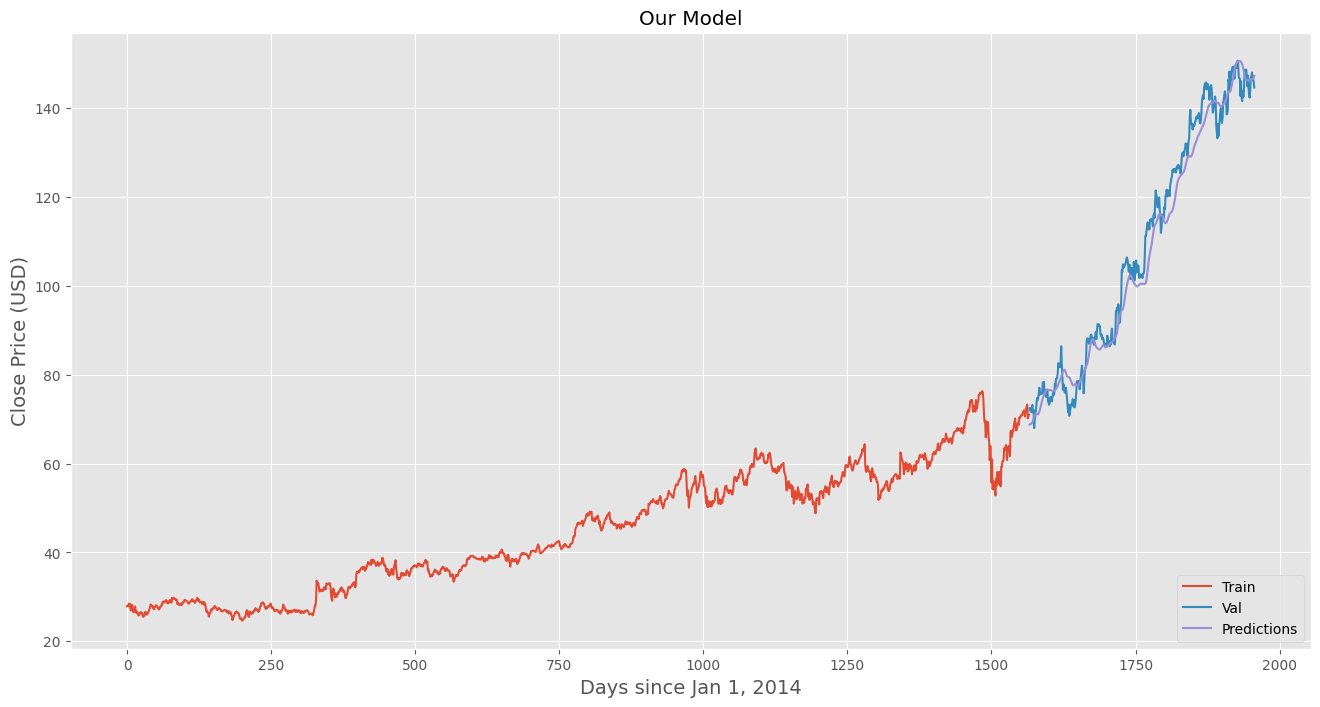

In [246]:
#Plotting
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Data visual
plt.figure(figsize=(16,8))
plt.title('Our Model')
plt.xlabel('Days since Jan 1, 2014', fontsize=14)
plt.ylabel('Close Price (USD)', fontsize=14)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train','Val','Predictions'], loc='lower right')
plt.show()